<a href="https://colab.research.google.com/github/Diego-Hernandez-Jimenez/prototype_learning_LVQ/blob/main/GMLVQ_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype-based learning. Part I: GMLVQ from scratch

This notebook contains the Python's implementation of Generalized Matrix Learning Vector Quantization (GMLVQ) and its localized version (LGMLVQ) as described in  [Schneider et al. (2009)](https://www.cs.rug.nl/~biehl/Preprints/gmlvq.pdf). One of their experiments is also replicated here.

In [1]:
import torch

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

## Dataset creation

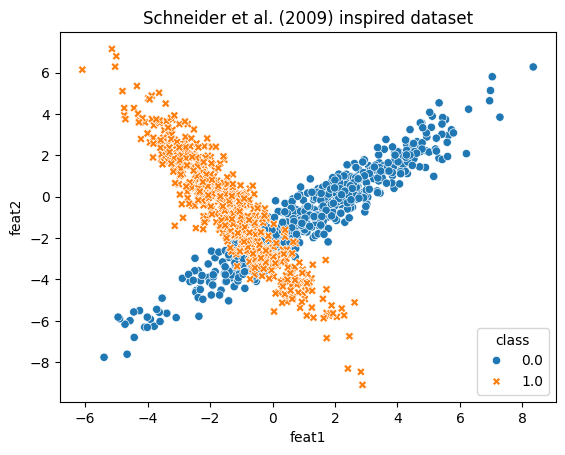

In [2]:
def create_artificial_data(n:int, seed:int) -> tuple:
  """
  The dataset consists of two clusters of data points,
    each generated from a different multivariate normal distribution with specific
    means, covariance matrices, and rotations (inspired by Schneider et al., 2009).

    Args:
        n (int): Number of samples to generate for each cluster.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: A tuple containing:
            - data (torch.utils.data.TensorDataset): A PyTorch TensorDataset containing
              the features and labels.
            - df (pandas.DataFrame): A pandas DataFrame containing the features and labels,
              where 'feat1' and 'feat2' are the feature columns and 'class' is the label column.

    Details:
        - Two clusters are generated from multivariate normal distributions with means
          [1.5, 0.0] and [-1.5, 0.0], and covariance matrices with diagonal values
          [0.5^2, 3.0^2].
        - The first cluster is rotated by pi/4 radians, and the second cluster by -pi/6 radians.
        - The final dataset is a combination of both clusters, with labels 0 for the first
          cluster and 1 for the second.

    Example:
        data, df = create_artificial_data(n=100, seed=42)
  """

  torch.manual_seed(seed)
  MV0 = torch.distributions.MultivariateNormal(
      loc=torch.tensor([1.5, 0.0]),
      covariance_matrix=torch.diag(torch.tensor([0.5, 3.0])).pow(2) # [0.1,3.0] [0.5,3.0]
  )
  MV1 = torch.distributions.MultivariateNormal(
      loc=torch.tensor([-1.5, 0.0]), # [-0.8,0.0]
      covariance_matrix=torch.diag(torch.tensor([0.5, 3.0])).pow(2) # [0.1,3.0] [0.5,3.0]
  )
  cluster0 = MV0.sample((1, n)).squeeze(0)
  cluster1 = MV1.sample((1, n)).squeeze(0)

  phi = torch.tensor([torch.pi/4, -torch.pi/6])
  rot_matrix0 = torch.tensor(
      [[torch.cos(phi[0]), -torch.sin(phi[0])],
      [torch.sin(phi[0]), torch.cos(phi[0])]]
  )
  rot_matrix1 = torch.tensor(
      [[torch.cos(phi[1]), -torch.sin(phi[1])],
      [torch.sin(phi[1]), torch.cos(phi[1])]]
  )
  X0 = torch.matmul(cluster0, rot_matrix0)
  X1 = torch.matmul(cluster1, rot_matrix1)
  X = torch.cat([X0, X1], dim=0)
  y = torch.cat([torch.zeros(n), torch.ones(n)])

  # tensor dataset
  data = torch.utils.data.TensorDataset(X, y)

  # pandas dataframe
  df = pd.DataFrame(X, columns=['feat1', 'feat2'])
  df['class'] = y

  return data, df


n = 600
data, df = create_artificial_data(n, seed=42)
p = sns.scatterplot(data=df, x="feat1", y="feat2", hue="class", style="class")
p.set_title('Schneider et al. (2009) inspired dataset')
plt.savefig('SchneiderGMLVQ_data.png', dpi=300)

In [3]:
def get_wclasses(n_prototypes_per_class:list) -> torch.tensor:
  """
   Generates a torch tensor where each element indicates the class associated
    with a prototype. The length of the tensor is equal to the total number of prototypes,
    and the value at each index represents the class ID of the corresponding prototype.

    Args:
        n_prototypes_per_class (list of int): A list where each element specifies the
        number of prototypes for each class. The index of the element represents the
        class ID.

    Returns:
        torch.Tensor: A tensor of length equal to the total number of prototypes. Each
        element in the tensor corresponds to a class ID, indicating the class associated
        with that prototype.

    Example:
        If `n_prototypes_per_class = [3, 2]`, the output tensor will be:
        tensor([0, 0, 0, 1, 1]), indicating 3 prototypes for class 0 and 2 prototypes for class 1.
  """

  Wclasses = []
  for class_id, times_each_proto in enumerate(n_prototypes_per_class):
    Wclasses.extend([class_id] * times_each_proto)

  return torch.tensor(Wclasses)


def dist_to_prototypes(x:torch.tensor, W:list, Q:torch.tensor, lvq_mode:str) -> torch.tensor:
  """
    Computes the distances between a given sample `x` and the prototypes in `W`,
    using a distance function that depends on the specified `lvq_mode`. The distances
    are calculated with the help of a matrix or matrices `Q`, depending on the mode.

    Args:
        x (torch.Tensor): A tensor representing the input sample. It should have the same
        dimensionality as the prototypes in `W`.

        W (list of torch.Tensor): A list containing the prototypes, where each element
        is a tensor representing a prototype. Each prototype has the same dimensionality
        as `x`.

        Q (torch.Tensor or list of torch.Tensor): A transformation matrix or a list of
        matrices used to compute the distance.
        - If `lvq_mode` is 'gmlvq', `Q` should be a single matrix.
        - If `lvq_mode` is 'lgmlvq', `Q` should be a list of matrices, one for each prototype.

        lvq_mode (str): Specifies the type of Learning Vector Quantization (LVQ) model to use.
        - 'gmlvq': Generalized Matrix Learning Vector Quantization, where a single matrix `Q` is used
          for all prototypes.
        - 'lgmlvq': Local Generalized Matrix Learning Vector Quantization, where each prototype
          has its own matrix `Q`.

    Returns:
        torch.Tensor: A tensor containing the computed distances between `x` and each prototype
        in `W`. The length of the output tensor is equal to the number of prototypes.

    Raises:
        ValueError: If an invalid `lvq_mode` is provided, or if the dimensions of `Q` do not match
        the requirements of the specified `lvq_mode`.

    Example:
        dists = dist_to_prototypes(x, W, Q, lvq_mode='gmlvq')
    """

  p = len(W)
  dists = torch.zeros(p)
  if lvq_mode == 'gmlvq':
    for j in range(p):
      raw_diff = x - W[j]
      dists[j] = torch.linalg.multi_dot([raw_diff, Q.t(), Q, raw_diff.t()])
      # dists[j] = torch.linalg.vector_norm(Q @ raw_diff.T, ord=2)**2

  elif lvq_mode == 'lgmlvq':
    for j in range(p):
      raw_diff = x - W[j]
      dists[j] = torch.linalg.multi_dot([raw_diff, Q[j].t(), Q[j], raw_diff.t()])
      # dists[j] = torch.linalg.vector_norm(Q[j] @ raw_diff.T, ord=2)**2

  else:
    print('choose appropiate lvq model')
    return None

  return dists


# def init_prototypes(data, n_prototypes_per_class):
#   random_ids = torch.randint(0, len(data), (sum(n_prototypes_per_class),))
#   W = [data[i][0] for i in random_ids]

#   return W

def init_prototypes(data:torch.utils.data.TensorDataset, n_prototypes_per_class:list) -> list:
  """
    Initializes prototypes for each class based on the input dataset. For each class, a
    specified number of prototypes is generated by averaging random subsets of samples
    from that class.

    Args:
        data (torch.utils.data.TensorDataset): A dataset containing features and labels.
        The dataset is expected to have two tensors:
        - `X`: A tensor of shape (n_samples, n_features) representing the feature vectors.
        - `y`: A tensor of shape (n_samples,) representing the class labels corresponding
          to each feature vector.

        n_prototypes_per_class (list of int): A list where each element specifies the
        number of prototypes to generate for the corresponding class. The index of the
        element represents the class ID.

    Returns:
        list of torch.Tensor: A list of tensors, where each tensor is a prototype. The length
        of the list is the total number of prototypes, and each prototype has the same
        dimensionality as the input features.

    Details:
        - For each class, the function identifies all samples belonging to that class.
        - It then creates the specified number of prototypes by randomly selecting subsets
          of these samples and averaging their feature vectors.
        - The size of each subset is determined by dividing the total number of samples
          in the class by the number of prototypes to be generated for that class.

    Example:
        If `n_prototypes_per_class = [2, 3]` and the dataset has two classes (0 and 1),
        the function will generate 2 prototypes for class 0 and 3 prototypes for class 1.

        W = init_prototypes_2(data, n_prototypes_per_class=[2, 3])
    """
  X, y = data.tensors
  W = []
  for class_id, times_each_proto in enumerate(n_prototypes_per_class):
    ids = torch.nonzero(y == class_id).squeeze()
    subset_size = (1/times_each_proto) * len(ids)
    subset_ids = ids[torch.randperm(len(ids))[:int(subset_size)]]
    w = X[subset_ids].mean(dim=0)
    W.append(w)

  return W


def init_pseudorelevance_matrix(n_prototypes_per_class:list, n_features:int, lvq_mode:str) -> torch.tensor:
  """
    Initializes the pseudorelevance matrix or matrices used in Learning Vector Quantization (LVQ) models.
    The initialization depends on the specified LVQ mode.

    Args:
        n_prototypes_per_class (list of int): A list where each element specifies the number
        of prototypes to generate for each class. The sum of this list gives the total number
        of prototypes.

        n_features (int): The number of features in the input data, which determines the size
        of the pseudorelevance matrix (or matrices).

        lvq_mode (str): Specifies the LVQ model type.
        - 'gmlvq': Generalized Matrix Learning Vector Quantization, where a single pseudorelevance
          matrix `Q` is used for all prototypes.
        - 'lgmlvq': Local Generalized Matrix Learning Vector Quantization, where each prototype
          has its own pseudorelevance matrix `Q`.

    Returns:
        torch.Tensor or list of torch.Tensor:
        - If `lvq_mode` is 'gmlvq', returns a single matrix `Q` of shape (n_features, n_features).
        - If `lvq_mode` is 'lgmlvq', returns a list of matrices `Q`, where each matrix is of
          shape (n_features, n_features) and corresponds to a prototype.

    Raises:
        ValueError: If an invalid `lvq_mode` is provided.

    Details:
        - In 'gmlvq' mode, a single matrix `Q` is initialized as the square root of the identity
          matrix divided by the number of features.
        - In 'lgmlvq' mode, a list of such matrices is created, with one matrix for each prototype.

    Example:
        Q = init_pseudorelevance_matrix(n_prototypes_per_class=[2, 3], n_features=5, lvq_mode='gmlvq')
    """

  n_prototypes_total = sum(n_prototypes_per_class)
  if lvq_mode == 'gmlvq':
    Q = torch.sqrt(torch.eye(n_features)/n_features)

  elif lvq_mode == 'lgmlvq':
    Q = [torch.sqrt(torch.eye(n_features)/n_features) for _ in range(n_prototypes_total)]

  else:
    print('choose appropiate lvq model')
    return None

  return Q


def relative_dist_loss(d_pos:torch.tensor, d_neg:torch.tensor, activ:str='linear') -> torch.tensor:
  """
    Computes the relative distance loss between positive and negative distances using a specified activation function.
    This loss is often used in Learning Vector Quantization (LVQ) models to measure the relative similarity between
    a sample and prototypes.

    Args:
        d_pos (torch.Tensor): The "positive distance", representing the distance between the sample and
        the closest correct prototype.

        d_neg (torch.Tensor): The "negative distance", representing the distance between the sample and
        the closest incorrect prototype.

        activ (str, optional): The activation function to apply to the relative distance.
        Default is 'linear'. Supported values are:
        - 'linear': No activation function (identity).
        - 'sigmoid': Applies a sigmoid activation to the result (careful, this is not supported in practice).

    Returns:
        torch.Tensor: The result of applying the activation function to the relative distance. The output is a tensor
        of the same shape as the input distances.

    Raises:
        KeyError: If an unsupported activation function is provided.

    Example:
        loss = relative_dist_loss(d_pos, d_neg, activ='sigmoid')

    Details:
        - The function first computes the relative difference between the positive and negative distances, normalized
          by their sum: `(d_pos - d_neg) / (d_pos + d_neg)`.
        - It then applies the specified activation function (`linear` or `sigmoid`) to this value.
    """

  dict_activations = {
      'linear': torch.nn.Identity(),
      'sigmoid': torch.nn.Sigmoid()
  }
  phi = dict_activations[activ]

  return phi( (d_pos - d_neg) / (d_pos + d_neg) )


def train_lvq(data:torch.utils.data.TensorDataset,
              Wclasses:list,
              W:list,
              Q:torch.tensor,
              lvq_mode:str,
              eta0:dict,
              tau:float,
              epochs:int) -> tuple:
  """
    Trains a Learning Vector Quantization (LVQ) model by updating prototypes and relevance matrices
    using gradient descent. The training process iteratively adjusts the prototypes and relevance matrices
    to minimize the classification error.

    Args:
        data (torch.utils.data.TensorDataset): The training dataset, containing feature vectors and corresponding
        class labels.

        W (list of torch.Tensor): A list of tensors representing the prototypes. Each tensor corresponds to a prototype.

        Q (torch.Tensor or list of torch.Tensor): The relevance matrix (or matrices) used to compute distances.
        - If `lvq_mode` is 'gmlvq', `Q` is a single matrix shared by all prototypes.
        - If `lvq_mode` is 'lgmlvq', `Q` is a list of matrices, one for each prototype.

        lvq_mode (str): Specifies the LVQ model type.
        - 'gmlvq': Generalized Matrix Learning Vector Quantization, where a single relevance matrix is used.
        - 'lgmlvq': Local Generalized Matrix Learning Vector Quantization, where each prototype has its own relevance matrix.

        eta0 (dict): A dictionary with initial learning rates for updating prototypes (`'W'`) and relevance matrices (`'Q'`).

        tau (float): A hyperparameter used to adjust the learning rate over time.

        epochs (int): The number of epochs to run the training process.

    Returns:
        tuple: A tuple containing the updated prototypes `W` and relevance matrices `Q`.

    Example:
        W, Q = train_lvq(data, W, Q, lvq_mode='lgmlvq', eta0={'W': 0.01, 'Q': 0.001}, tau=0.5, epochs=100)

    Details:
        - The function iterates through the dataset for the specified number of epochs.
        - For each sample, it computes the distances to all prototypes using `dist_to_prototypes`.
        - The prototype closest to the correct class and the prototype closest to the incorrect class are identified.
        - Gradients are computed with respect to the prototypes and relevance matrices to minimize the loss, which is calculated using `relative_dist_loss`.
        - The prototypes and relevance matrices are updated using gradient descent, with learning rates controlled by `eta0` and `tau`.
        - In the case of 'lgmlvq', separate updates are performed for each prototype's relevance matrix, while in 'gmlvq', a single relevance matrix is updated.
        - Relevance matrices are normalized after each update to maintain constraints.

    Raises:
        ValueError: If an invalid `lvq_mode` is provided or if other input parameters are not compatible with the training process.

    Notes:
        - The learning rate for the prototypes remains constant, while the learning rate for the relevance matrices decreases over time based on the epoch number.
    """

  n = len(data)
  for epoch in range(epochs):
    for i in torch.randperm(n):
      x, lab = data[i]
      d = dist_to_prototypes(x, W, Q, lvq_mode)
      d_pos= torch.min(d[Wclasses == lab])
      id_winner = torch.argwhere(d == d_pos)
      w_pos = W[id_winner]
      Q_pos = Q[id_winner]

      d_neg = torch.min(d[Wclasses != lab])
      id_loser = torch.argwhere(d == d_neg)
      w_neg = W[id_loser]
      Q_neg = Q[id_loser]

      loss = relative_dist_loss(d_pos, d_neg)

      # DERIVATIVES
      dloss_dmu = 1
      dmu_ddpos = (2*d_neg) / torch.pow(d_pos + d_neg, 2)
      dmu_ddneg = (-2*d_pos) / torch.pow(d_pos + d_neg, 2)

      if lvq_mode == 'lgmlvq':
        ddpos_dwpos = (-2) * torch.linalg.multi_dot([Q_pos.T, Q_pos, (x - w_pos)])
        ddneg_dwneg = (-2) * torch.linalg.multi_dot([Q_neg.T, Q_neg, (x - w_neg)])

        ddpos_dQpos = 2 * torch.linalg.matmul(Q_pos, torch.outer(x - w_pos, x - w_pos))
        ddneg_dQneg = 2 * torch.linalg.matmul(Q_neg, torch.outer(x - w_neg, x - w_neg))

      else:
        ddpos_dwpos = (-2) * torch.linalg.multi_dot([Q.T, Q, (x - w_pos)])
        ddneg_dwneg = (-2) * torch.linalg.multi_dot([Q.T, Q, (x - w_neg)])

        ddpos_dQpos = 2 * torch.linalg.matmul(Q, torch.outer(x - w_pos, x - w_pos))
        ddneg_dQneg = 2 * torch.linalg.matmul(Q, torch.outer(x - w_neg, x - w_neg))

      dloss_dwpos = dloss_dmu * dmu_ddpos * ddpos_dwpos
      dloss_dwneg = dloss_dmu * dmu_ddneg * ddneg_dwneg

      dloss_dQpos = dloss_dmu * dmu_ddpos * ddpos_dQpos
      dloss_dQneg = dloss_dmu * dmu_ddneg * ddneg_dQneg

      if lvq_mode == 'gmlvq':
        dloss_dQ = dloss_dQpos + dloss_dQneg
      else:
        pass


      # PARAMETERS UPDATE
      # uncomment for dynamic prototype learning rate
      # eta = (4*eta0['W'])/(1 + tau*(epoch - 1))
      eta = eta0['W']
      W[id_winner] = w_pos - eta * dloss_dwpos
      W[id_loser] = w_neg - eta * dloss_dwneg

      eta = (4*eta0['Q'])/(1 + tau*(epoch - 1))
      # uncomment for fixed pseudo-relevance learning rate
      # eta = eta0['Q']

      if lvq_mode == 'gmlvq':
        Q -= eta * dloss_dQ
        Q = Q / torch.sqrt( (Q.T @ Q).diag().sum() )
      else:
        Q_pos -= eta * dloss_dQpos

        # transform Q_pos and Q_neg to satisfy constraints
        Q_pos = Q_pos / torch.sqrt( (Q_pos.T @ Q_pos).diag().sum() )
        Q[id_winner] = Q_pos

        Q_neg -= eta * dloss_dQneg
        Q_neg = Q_neg / torch.sqrt( (Q_neg.T @ Q_neg).diag().sum() )
        Q[id_loser] = Q_neg


  return W, Q


def predict_class(X:torch.tensor, Wclasses:list, W:list, Q:torch.tensor, lvq_mode:str) -> torch.tensor:
  """
    Predicts the class labels for a set of input samples based on their distances to prototypes.
    The function uses a specified Learning Vector Quantization (LVQ) mode to calculate these distances.

    Args:
        X (torch.Tensor): A tensor of shape (n_samples, n_features) containing the input samples for which
        the class labels are to be predicted.

        Wclasses (torch.Tensor): A tensor containing the class labels associated with each prototype. The length
        of `Wclasses` should match the number of prototypes.

        W (list of torch.Tensor): A list of tensors where each tensor represents a prototype. The prototypes
        have the same dimensionality as the input samples in `X`.

        Q (torch.Tensor or list of torch.Tensor): The transformation matrix (or matrices) used to compute the
        distance between the samples and prototypes.
        - If `lvq_mode` is 'gmlvq', `Q` should be a single matrix.
        - If `lvq_mode` is 'lgmlvq', `Q` should be a list of matrices, one for each prototype.

        lvq_mode (str): Specifies the type of LVQ model to use for distance computation.
        - 'gmlvq': Generalized Matrix Learning Vector Quantization, where a single matrix `Q` is used for all prototypes.
        - 'lgmlvq': Local Generalized Matrix Learning Vector Quantization, where each prototype has its own matrix `Q`.

    Returns:
        torch.Tensor: A tensor of predicted class labels for each input sample in `X`. The length of the output tensor
        is equal to the number of input samples.

    Example:
        preds = predict_class(X, Wclasses, W, Q, lvq_mode='gmlvq')

    Details:
        - For each input sample in `X`, the function computes the distances to all prototypes using the
          `dist_to_prototypes` function.
        - The class label associated with the prototype that has the minimum distance to the sample is selected
          as the predicted class.
        - The function iterates over all input samples to generate predictions for each one.
    """

  preds = torch.zeros(X.shape[0])
  for i in range(X.shape[0]):
    x = X[i]
    d = dist_to_prototypes(x, W, Q, lvq_mode)
    preds[i] = Wclasses[torch.argmin(d)]

  return preds

## Model creation and learning

In [5]:
n_features = 2 # features
n_categories = 2 # classes

n_prototypes_per_class = [1, 1]
n_prototypes = sum(n_prototypes_per_class)
W = init_prototypes(data, n_prototypes_per_class)
Wclasses = get_wclasses(n_prototypes_per_class)

# init pseudo-relevance matrix
lvq_mode = 'lgmlvq' # gmlvq: one matrix, lgmlvq: one matrix per prototype
Q = init_pseudorelevance_matrix(n_prototypes_per_class, n_features, lvq_mode)

eta0 = {'W': 0.005, 'Q': 0.001}
tau = 0.001

epochs = 25

W, Q = train_lvq(data, Wclasses, W, Q, lvq_mode, eta0, tau, epochs)
print('Prototypes:')
print(W)
print('')

if lvq_mode == 'gmlvq':
  R = Q.T @ Q # relevance matrix
  print('Relevance matrix:')
  print(R)
else:
  R1 = Q[0].T @ Q[0] # relevance matrix
  R2 = Q[1].T @ Q[1]
  print('Relevance matrix 1:')
  print(R1)
  print('')
  print('Relevance matrix 2:')
  print(R2)

Prototypes:
[tensor([ 0.7501, -1.5721]), tensor([-1.0854, -1.2086])]

Relevance matrix 1:
tensor([[ 0.5628, -0.4960],
        [-0.4960,  0.4372]])

Relevance matrix 2:
tensor([[0.6877, 0.4634],
        [0.4634, 0.3123]])


## Validation

In [6]:
X, y = data.tensors
preds = predict_class(X, Wclasses, W, Q, lvq_mode)

# accuracy
(y == preds).float().mean()

tensor(0.9083)

In [7]:
# test_data, df_test = create_artificial_data(n, seed=13)

# Xtest, ytest = test_data.tensors
# preds = predict_class(Xtest, Wclasses, W, Q, lvq_mode)
# (ytest == preds).float().mean()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


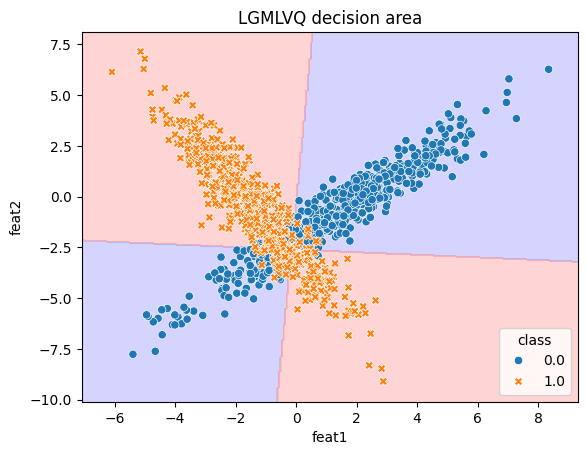

In [8]:
# decision area plot

# limits of the plot
x_min, x_max = df['feat1'].min() - 1, df['feat1'].max() + 1
y_min, y_max = df['feat2'].min() - 1, df['feat2'].max() + 1

# grid of points
xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.05),
                         torch.arange(y_min, y_max, 0.05))

# convert grid into tensor of features
grid_tensor = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# predict class for every point in the grid
predicted_classes = predict_class(grid_tensor, Wclasses, W, Q, lvq_mode)

# convert predicted_classes into numpy object to be able to plot results
Z = predicted_classes.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['#AAAAFF', '#FFAAAA']))


p = sns.scatterplot(data=df, x='feat1', y='feat2', hue='class', style='class')
plt.xlabel('feat1')
plt.ylabel('feat2')
plt.title(f'{lvq_mode.upper()} decision area')
plt.savefig(f'{lvq_mode.upper()}_decision_area.png', dpi=300)
plt.show()

Credit to ChatGPT for helping me write the docstrings